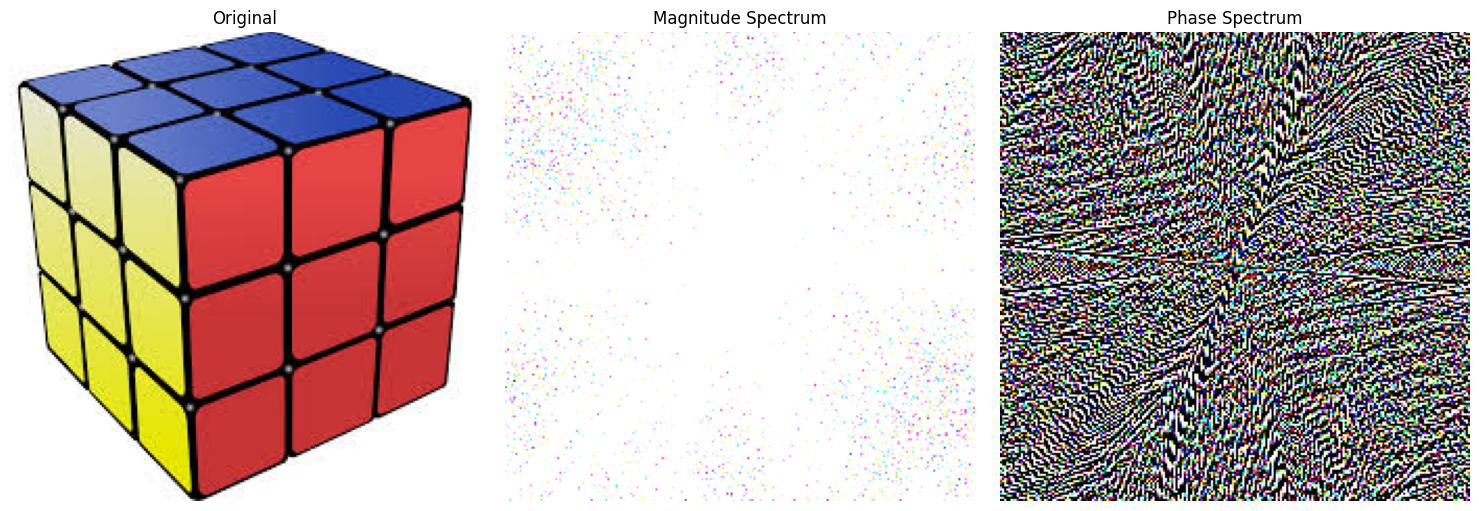

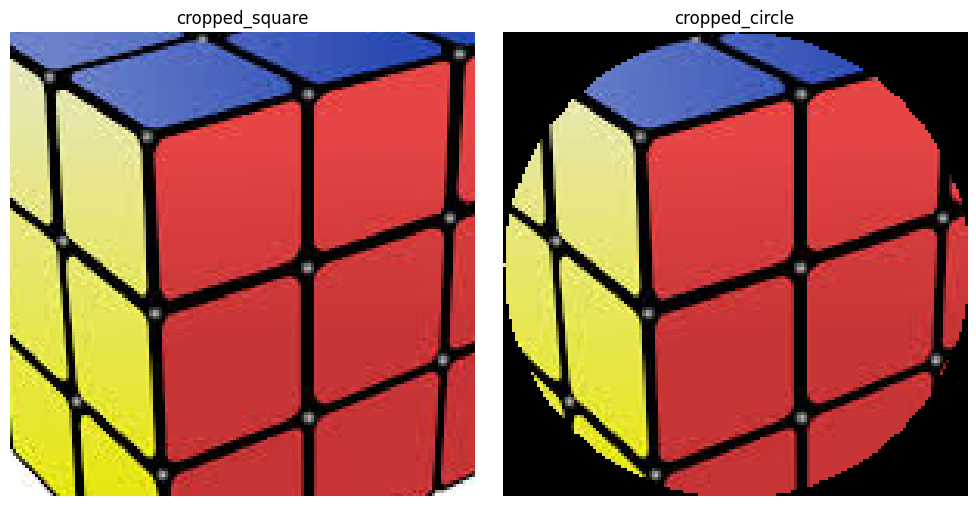

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Union
from pathlib import Path
from numpy.fft import fft2, fftshift


def load_image(filepath: Union[str, Path], as_gray: bool = False) -> np.ndarray:
    """
    Load an image using OpenCV, optionally as grayscale, and convert to float32 normalized [0, 1].

    :param filepath: Path to the image file.
    :param as_gray: If True, loads as grayscale. If False, loads as RGB.
    :return: Normalized np.ndarray image.
    """
    filepath = Path(filepath)
    if not filepath.exists():
        raise FileNotFoundError(f"Image path not found: {filepath}")

    flag = cv2.IMREAD_GRAYSCALE if as_gray else cv2.IMREAD_COLOR
    img = cv2.imread(str(filepath), flag)

    if img is None:
        raise ValueError(f"Failed to load image from: {filepath}")

    if not as_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img.astype(np.float32) / 255.0


def crop_circle_or_square_from_middle(img: np.ndarray, crop_size: int, circle: bool = False, radius: int = None) -> np.ndarray:
    """
    Crop a square or circular region from the center of an image.

    :param img: Input image (2D grayscale or 3D RGB), dtype float or uint8.
    :param crop_size: Side length of the central square crop (ignored if circle=True).
    :param circle: If True, applies a circular crop instead of a square.
    :param radius: Radius of circular crop (required if circle=True).
    :return: Cropped or masked image.
    """
    if img.ndim not in (2, 3):
        raise ValueError("Input image must be 2D (grayscale) or 3D (RGB).")

    H, W = img.shape[:2]

    if circle:
        if radius is None:
            raise ValueError("You must provide a radius for circular cropping.")
        if radius <= 0 or radius > min(H, W) // 2:
            raise ValueError(f"Invalid radius: {radius}. Must be > 0 and <= {min(H, W) // 2}")

        # Create circular mask centered in the image
        center = (W // 2, H // 2)
        mask = np.zeros((H, W), dtype=np.uint8)
        cv2.circle(mask, center, radius, 1, thickness=-1)

        # Apply mask to image
        if img.ndim == 2:  # Grayscale
            masked = img * mask
        else:  # RGB
            mask_3d = np.stack([mask] * 3, axis=-1)
            masked = img * mask_3d

        # Crop a bounding square around the circle
        top = center[1] - radius
        left = center[0] - radius
        return masked[top:top + 2 * radius, left:left + 2 * radius]  # shape: (2r, 2r) or (2r, 2r, 3)

    # Handle square crop
    if crop_size <= 0 or crop_size > min(H, W):
        raise ValueError(f"Invalid crop size: {crop_size}. Must be > 0 and <= image size.")

    top = (H - crop_size) // 2
    left = (W - crop_size) // 2

    return img[top:top + crop_size, left:left + crop_size] if img.ndim == 2 \
           else img[top:top + crop_size, left:left + crop_size, :]


def fourier_transform(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute the 2D Fourier transform of a grayscale or RGB image.

    :param img: Normalized image (2D or 3D).
    :return: Tuple of (fft_abs, magnitude_spectrum, phase_spectrum)
    """
    if img.ndim == 2:
        fft = fftshift(fft2(img))
    elif img.ndim == 3:
        fft = fftshift(fft2(img, axes=(0, 1)), axes=(0, 1))
    else:
        raise ValueError("Image must be 2D or 3D.")

    magnitude = np.log(1 + np.abs(fft))
    phase = np.angle(fft)
    return np.abs(fft), magnitude, phase


def plot_images(images: List[np.ndarray], titles: List[str]) -> None:
    """
    Display a list of images with corresponding titles.

    :param images: List of image arrays.
    :param titles: List of titles.
    """
    if len(images) != len(titles):
        raise ValueError("Images and titles must have the same length.")

    fig, axs = plt.subplots(1, len(images), figsize=(5 * len(images), 5))

    if len(images) == 1:
        axs = [axs]

    for ax, img, title in zip(axs, images, titles):
        if img.ndim == 2:
            ax.imshow(img, cmap="gray")
        elif img.ndim == 3:
            ax.imshow(np.clip(img, 0, 1))
        else:
            raise ValueError("Images must be 2D or 3D.")
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def main():
    rubik_path = "/Users/ryanqchiqache/Downloads/rubix_cube_image.jpeg"

    img = load_image(rubik_path, as_gray=False)

    fft_abs, magnitude, phase = fourier_transform(img)

    plot_images(
        images=[img, magnitude, phase],
        titles=["Original", "Magnitude Spectrum", "Phase Spectrum"]
    )
    
    cropped_square = crop_circle_or_square_from_middle(img, 150)
    cropped_circle = crop_circle_or_square_from_middle(img,10,  True, 75)
    
    plot_images(images=[cropped_square, cropped_circle], titles=["cropped_square", "cropped_circle"])


main()


